**Assignment-2 - Convolutional Neural Networks(CNN)**

A convolutional neural network can detect and classify objects in an image.The main objective of this assignment is to apply convnet to images and assess their performance based on pre-trained networks.

Here we will be downloading the data using an API token from Kaggle Personal Account.

In [2]:

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manasachelukala","key":"504f8855f9c348dcaa2dc9cddd064c75"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:20<00:00, 46.0MB/s]
100% 812M/812M [00:20<00:00, 40.7MB/s]


In [6]:
!unzip -qq dogs-vs-cats.zip

In [7]:
!unzip -qq train.zip

**Question-1**

Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

We will develop a convolutional neural network from scratch here. Now that we have loaded the dataset, we can create subsets of it for our training, validation, and test data.In this case, we use 1000 images for training, 500 for validation, and 500 for testing.

Dividing the Dataset into Train, Validation and Test

In [8]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("test", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=2000)

### Building the model

Our input for this network is images (a 3D tensor), which needs to be reshaped first.We then use convolution with a window size of 3x3 (kernel_size) and maxpooling with a 2x2 window (pool_size).

This assignment aims to classify images; therefore, we use a dense layer as a final layer to determine whether the output is classified as a "cat" or a "dog".There is only one output node, either "cat" or "dog".To feed the dense layer, we first need a layer that flattens the 3D shape into 1D.

**Instantiating a small convnet for dogs vs. cats classification**

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

From the above summary,we can see that there are 991,041 parameters to optimize.

**Configuring the model for training**

In [11]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Data preprocessing**

**Using `image_dataset_from_directory` to read images**

This code Modifies the  images to tensors in their specific folders of training,validation and test.

In [12]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [13]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [14]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [15]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [16]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [17]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In this case, we will use "callbacks" because they will automatically store a file containing the weights generated from the best epoch, so we do not need to retrain the model.

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 14s 85ms/step - loss: 0.7833 - accuracy: 0.5050 - val_loss: 0.6916 - val_accuracy: 0.5110
Epoch 2/30
63/63 [==============================] - 5s 75ms/step - loss: 0.6898 - accuracy: 0.5380 - val_loss: 0.6687 - val_accuracy: 0.5700
Epoch 3/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6832 - accuracy: 0.6130 - val_loss: 0.6753 - val_accuracy: 0.6090
Epoch 4/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6390 - accuracy: 0.6335 - val_loss: 0.7023 - val_accuracy: 0.5770
Epoch 5/30
63/63 [==============================] - 5s 71ms/step - loss: 0.6042 - accuracy: 0.6685 - val_loss: 0.5938 - val_accuracy: 0.6800
Epoch 6/30
63/63 [==============================] - 5s 72ms/step - loss: 0.5819 - accuracy: 0.6975 - val_loss: 0.6274 - val_accuracy: 0.6690
Epoch 7/30
63/63 [==============================] - 5s 71ms/step - loss: 0.5415 - accuracy: 0.7305 - val_loss: 0.6298 - val_accuracy: 0.6750
Epoch 8/30
6

**Displaying curves of loss and accuracy during training**

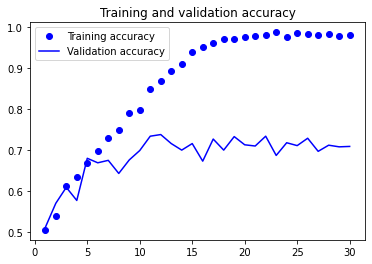

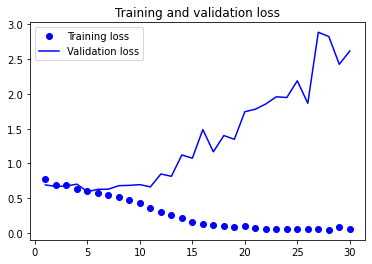

In [19]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [20]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 36ms/step - loss: 0.5584 - accuracy: 0.7000
Test accuracy: 0.700


The validation and test accuracy of the model tends to be very low which is 70%.

In order to improve the model performance, we will train our model using few techniques like 

 a) Data Augmentation 

 b) Drop out Method 

 c) Data Augmentation and drop out method



**a)Using Data Augmentation**

Defining a data augmentation stage to add to an image model

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Defining a new convnet that includes image augmentation

In [22]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [23]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
     callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 8s 97ms/step - loss: 0.7425 - accuracy: 0.5195 - val_loss: 0.6915 - val_accuracy: 0.5230
Epoch 2/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6969 - accuracy: 0.5305 - val_loss: 0.6876 - val_accuracy: 0.5340
Epoch 3/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6943 - accuracy: 0.5670 - val_loss: 0.6629 - val_accuracy: 0.5730
Epoch 4/100
63/63 [==============================] - 6s 99ms/step - loss: 0.6832 - accuracy: 0.6115 - val_loss: 0.6530 - val_accuracy: 0.6150
Epoch 5/100
63/63 [==============================] - 6s 94ms/step - loss: 0.6535 - accuracy: 0.6145 - val_loss: 0.6677 - val_accuracy: 0.6310
Epoch 6/100
63/63 [==============================] - 6s 94ms/step - loss: 0.6408 - accuracy: 0.6450 - val_loss: 0.6752 - val_accuracy: 0.6550
Epoch 7/100
63/63 [==============================] - 6s 98ms/step - loss: 0.6292 - accuracy: 0.6685 - val_loss: 0.5794 - val_accuracy: 0.6970
Epoch 

Evaluating the test dataset

In [24]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 35ms/step - loss: 0.4040 - accuracy: 0.8400
Test accuracy: 0.840


**b) Using Dropout method**

Defining a new convnet that includes dropout

In [25]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 6s 75ms/step - loss: 0.7804 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.5250
Epoch 2/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6971 - accuracy: 0.5365 - val_loss: 0.6780 - val_accuracy: 0.5650
Epoch 3/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6840 - accuracy: 0.5570 - val_loss: 0.6853 - val_accuracy: 0.5370
Epoch 4/30
63/63 [==============================] - 5s 75ms/step - loss: 0.6609 - accuracy: 0.6140 - val_loss: 0.6693 - val_accuracy: 0.5830
Epoch 5/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6530 - accuracy: 0.6360 - val_loss: 0.6282 - val_accuracy: 0.6300
Epoch 6/30
63/63 [==============================] - 5s 74ms/step - loss: 0.6340 - accuracy: 0.6635 - val_loss: 0.6113 - val_accuracy: 0.6680
Epoch 7/30
63/63 [==============================] - 5s 72ms/step - loss: 0.5948 - accuracy: 0.6920 - val_loss: 0.5883 - val_accuracy: 0.6840
Epoch 8/30
63

Evaluating the test dataset



In [27]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 35ms/step - loss: 0.5242 - accuracy: 0.7380
Test accuracy: 0.738


**c) Using Image Augmentation and Dropout method**

Defining  a data augmentation stage to add to an image model

In [28]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Defining a new convnet that includes image augmentation and dropout

In [29]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convnet

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 8s 102ms/step - loss: 0.7290 - accuracy: 0.5155 - val_loss: 0.6931 - val_accuracy: 0.5100
Epoch 2/100
63/63 [==============================] - 6s 96ms/step - loss: 0.6958 - accuracy: 0.5140 - val_loss: 0.6907 - val_accuracy: 0.5290
Epoch 3/100
63/63 [==============================] - 6s 95ms/step - loss: 0.6965 - accuracy: 0.5340 - val_loss: 0.6860 - val_accuracy: 0.5170
Epoch 4/100
63/63 [==============================] - 6s 94ms/step - loss: 0.6884 - accuracy: 0.5840 - val_loss: 0.6696 - val_accuracy: 0.5890
Epoch 5/100
63/63 [==============================] - 7s 115ms/step - loss: 0.6778 - accuracy: 0.5960 - val_loss: 0.7078 - val_accuracy: 0.5880
Epoch 6/100
63/63 [==============================] - 7s 101ms/step - loss: 0.6612 - accuracy: 0.6095 - val_loss: 0.6364 - val_accuracy: 0.6340
Epoch 7/100
63/63 [==============================] - 6s 93ms/step - loss: 0.6667 - accuracy: 0.6525 - val_loss: 0.6434 - val_accuracy: 0.6320
Epo

In [31]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 34ms/step - loss: 0.3917 - accuracy: 0.8640
Test accuracy: 0.864


**Q2. Increasing Training sample size to 5000 samples**

The training samples have been increased to 5000 and the model performance has been evaluated and have explained in the summary.

From the above model performance techniques,here i will be using the data augmentation and drop out method because the performance of the model has been improved using this.

In [32]:
make_subset("train3", start_index=1000, end_index=6000)

train_dataset_3 = image_dataset_from_directory(
    new_base_dir / "train3",
    image_size=(180, 180),
    batch_size=32)

Found 10000 files belonging to 2 classes.


Defining a new convnet that includes image augmentation and dropout

In [33]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularised convnet

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset_3,
    epochs=70,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/70
313/313 [==============================] - 18s 54ms/step - loss: 0.7167 - accuracy: 0.5519 - val_loss: 0.7384 - val_accuracy: 0.5610
Epoch 2/70
313/313 [==============================] - 17s 54ms/step - loss: 0.6112 - accuracy: 0.6741 - val_loss: 0.5170 - val_accuracy: 0.7400
Epoch 3/70
313/313 [==============================] - 17s 54ms/step - loss: 0.5214 - accuracy: 0.7407 - val_loss: 0.4966 - val_accuracy: 0.7530
Epoch 4/70
313/313 [==============================] - 17s 54ms/step - loss: 0.4627 - accuracy: 0.7883 - val_loss: 0.4087 - val_accuracy: 0.8180
Epoch 5/70
313/313 [==============================] - 17s 54ms/step - loss: 0.4020 - accuracy: 0.8177 - val_loss: 0.4483 - val_accuracy: 0.7890
Epoch 6/70
313/313 [==============================] - 17s 53ms/step - loss: 0.3611 - accuracy: 0.8416 - val_loss: 0.3800 - val_accuracy: 0.8300
Epoch 7/70
313/313 [==============================] - 17s 55ms/step - loss: 0.3100 - accuracy: 0.8651 - val_loss: 0.3371 - val_accuracy:

In [35]:
test_model = keras.models.load_model(
    "convnet_from_scratch3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 36ms/step - loss: 0.3669 - accuracy: 0.8480
Test accuracy: 0.848


**Q3. Increasing the Training samples to 10000 Samples**

Here ,the training samples were increased from 5000 to 10000, in order to evaluate the model performance. The observations will be included in the summary.

In [36]:
#import shutil
#shutil.rmtree('/content/cats_vs_dogs_small/train2')

make_subset("train2", start_index=1000, end_index=11000)

train_dataset2 = image_dataset_from_directory(
    new_base_dir / "train2",
    image_size=(180, 180),
    batch_size=32)

Found 20000 files belonging to 2 classes.



**Model Building with Image augmentation and dropout.**


Defining a new convnet that includes image augmentation and dropout 


In [37]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
#x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_test3.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset_3,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
313/313 [==============================] - 18s 54ms/step - loss: 0.7001 - accuracy: 0.5650 - val_loss: 0.6598 - val_accuracy: 0.5830
Epoch 2/30
313/313 [==============================] - 17s 54ms/step - loss: 0.5930 - accuracy: 0.6912 - val_loss: 0.5523 - val_accuracy: 0.7320
Epoch 3/30
313/313 [==============================] - 17s 54ms/step - loss: 0.5103 - accuracy: 0.7570 - val_loss: 0.5086 - val_accuracy: 0.7550
Epoch 4/30
313/313 [==============================] - 17s 53ms/step - loss: 0.4430 - accuracy: 0.7970 - val_loss: 0.6518 - val_accuracy: 0.6890
Epoch 5/30
313/313 [==============================] - 17s 53ms/step - loss: 0.3944 - accuracy: 0.8260 - val_loss: 0.4123 - val_accuracy: 0.8270
Epoch 6/30
313/313 [==============================] - 17s 54ms/step - loss: 0.3286 - accuracy: 0.8601 - val_loss: 0.5802 - val_accuracy: 0.7570
Epoch 7/30
313/313 [==============================] - 17s 54ms/step - loss: 0.2738 - accuracy: 0.8840 - val_loss: 0.4119 - val_accuracy:

In [39]:
test_model = keras.models.load_model(
    "convnet_from_scratch_test3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 35ms/step - loss: 0.3956 - accuracy: 0.8420
Test accuracy: 0.842


In [40]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularised convnet

In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset2,
    epochs=70,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/70
625/625 [==============================] - 33s 51ms/step - loss: 0.6503 - accuracy: 0.6301 - val_loss: 0.5790 - val_accuracy: 0.7130
Epoch 2/70
625/625 [==============================] - 32s 51ms/step - loss: 0.4861 - accuracy: 0.7692 - val_loss: 0.4074 - val_accuracy: 0.8180
Epoch 3/70
625/625 [==============================] - 32s 50ms/step - loss: 0.3996 - accuracy: 0.8245 - val_loss: 0.3264 - val_accuracy: 0.8580
Epoch 4/70
625/625 [==============================] - 32s 50ms/step - loss: 0.3269 - accuracy: 0.8608 - val_loss: 0.2580 - val_accuracy: 0.8960
Epoch 5/70
625/625 [==============================] - 32s 50ms/step - loss: 0.2720 - accuracy: 0.8852 - val_loss: 0.2210 - val_accuracy: 0.9120
Epoch 6/70
625/625 [==============================] - 32s 50ms/step - loss: 0.2335 - accuracy: 0.9062 - val_loss: 0.2512 - val_accuracy: 0.8920
Epoch 7/70
625/625 [==============================] - 32s 51ms/step - loss: 0.2039 - accuracy: 0.9196 - val_loss: 0.2208 - val_accuracy:

Evaluating the test data

In [42]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 35ms/step - loss: 0.2235 - accuracy: 0.9120
Test accuracy: 0.912


**Q4.Fine Tuning of the pretrained models**

Using different training sample sizes, we will fine tune the pretrained model and evaluate its performance on the models we built earlier.

**Pre-Trained Model - 1000 Training samples**

Instantiating and freezing the VGG16 convolutional base

In [43]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [44]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Fine-tuning a pretrained model

In [45]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

Freezing all layers until the fourth from the last

In [46]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Adding a data augmentation stage and a classifier to the convolutional base

In [47]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [48]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 20s 252ms/step - loss: 3.6912 - accuracy: 0.7480 - val_loss: 0.6826 - val_accuracy: 0.9110
Epoch 2/30
63/63 [==============================] - 14s 220ms/step - loss: 1.0445 - accuracy: 0.8520 - val_loss: 0.3729 - val_accuracy: 0.9370
Epoch 3/30
63/63 [==============================] - 14s 223ms/step - loss: 0.5899 - accuracy: 0.8955 - val_loss: 0.2699 - val_accuracy: 0.9460
Epoch 4/30
63/63 [==============================] - 14s 222ms/step - loss: 0.3428 - accuracy: 0.9290 - val_loss: 0.2331 - val_accuracy: 0.9560
Epoch 5/30
63/63 [==============================] - 14s 222ms/step - loss: 0.3107 - accuracy: 0.9265 - val_loss: 0.2170 - val_accuracy: 0.9600
Epoch 6/30
63/63 [==============================] - 14s 219ms/step - loss: 0.2564 - accuracy: 0.9340 - val_loss: 0.1662 - val_accuracy: 0.9600
Epoch 7/30
63/63 [==============================] - 14s 218ms/step - loss: 0.2076 - accuracy: 0.9370 - val_loss: 0.1652 - val_accuracy: 0.9610

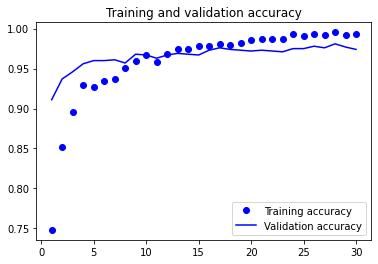

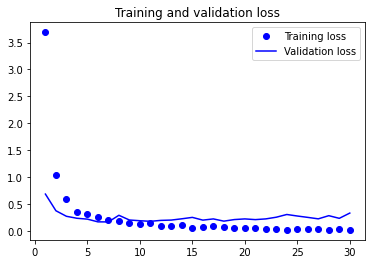

In [49]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [50]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 110ms/step - loss: 0.1391 - accuracy: 0.9680
Test accuracy: 0.968


**Pre-Trained Model - 5000 Training samples**

Instantiating and freezing the VGG16 convolutional base

In [51]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

Fine tuning the pretrained model and freezing the layers

In [52]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Adding a data augmentation stage and a classifier to the convolutional base

In [53]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning2.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset_3,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
313/313 [==============================] - 56s 172ms/step - loss: 1.3488 - accuracy: 0.8621 - val_loss: 0.1579 - val_accuracy: 0.9690
Epoch 2/10
313/313 [==============================] - 54s 170ms/step - loss: 0.2274 - accuracy: 0.9361 - val_loss: 0.1463 - val_accuracy: 0.9720
Epoch 3/10
313/313 [==============================] - 54s 172ms/step - loss: 0.1447 - accuracy: 0.9467 - val_loss: 0.1190 - val_accuracy: 0.9740
Epoch 4/10
313/313 [==============================] - 54s 171ms/step - loss: 0.1174 - accuracy: 0.9587 - val_loss: 0.1035 - val_accuracy: 0.9740
Epoch 5/10
313/313 [==============================] - 54s 171ms/step - loss: 0.1055 - accuracy: 0.9654 - val_loss: 0.1202 - val_accuracy: 0.9730
Epoch 6/10
313/313 [==============================] - 53s 170ms/step - loss: 0.0849 - accuracy: 0.9722 - val_loss: 0.1966 - val_accuracy: 0.9760
Epoch 7/10
313/313 [==============================] - 54s 170ms/step - loss: 0.0817 - accuracy: 0.9730 - val_loss: 0.1369 - val_ac

In [55]:
model = keras.models.load_model("fine_tuning2.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 109ms/step - loss: 0.0886 - accuracy: 0.9790
Test accuracy: 0.979


**Pre-Trained Model - 10000 samples**

Instantiating and freezing the VGG16 convolutional base

In [56]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

Fine tuning the pretrained model and freezing the layers

In [57]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False


Adding a data augmentation stage and a classifier to the convolutional base

In [58]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset2,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 106s 166ms/step - loss: 0.7787 - accuracy: 0.8945 - val_loss: 0.1456 - val_accuracy: 0.9700
Epoch 2/30
625/625 [==============================] - 104s 165ms/step - loss: 0.1427 - accuracy: 0.9506 - val_loss: 0.1381 - val_accuracy: 0.9740
Epoch 3/30
625/625 [==============================] - 104s 165ms/step - loss: 0.1131 - accuracy: 0.9607 - val_loss: 0.1275 - val_accuracy: 0.9750
Epoch 4/30
625/625 [==============================] - 103s 165ms/step - loss: 0.0949 - accuracy: 0.9688 - val_loss: 0.1399 - val_accuracy: 0.9750
Epoch 5/30
625/625 [==============================] - 103s 164ms/step - loss: 0.0961 - accuracy: 0.9696 - val_loss: 0.1491 - val_accuracy: 0.9770
Epoch 6/30
625/625 [==============================] - 103s 164ms/step - loss: 0.0819 - accuracy: 0.9738 - val_loss: 0.1702 - val_accuracy: 0.9800
Epoch 7/30
625/625 [==============================] - 105s 167ms/step - loss: 0.0806 - accuracy: 0.9756 - val_loss: 0.1446 -

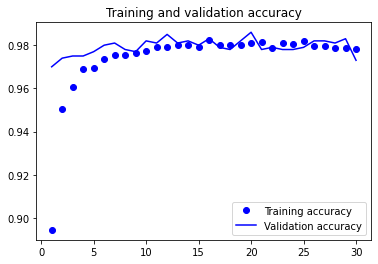

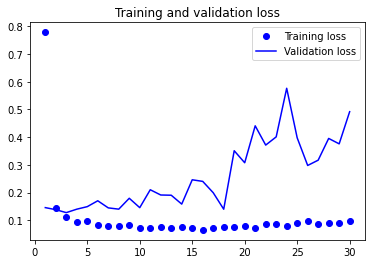

In [59]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [61]:

model = keras.models.load_model("fine_tuning3.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 107ms/step - loss: 0.0827 - accuracy: 0.9790
Test accuracy: 0.979


**Summary:**

**1.Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?**

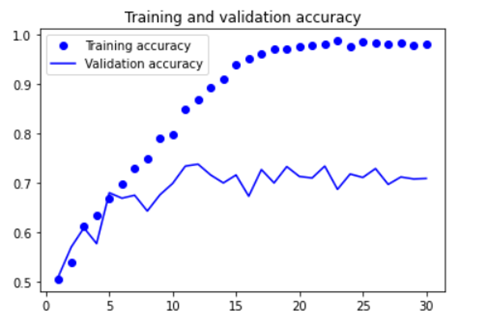

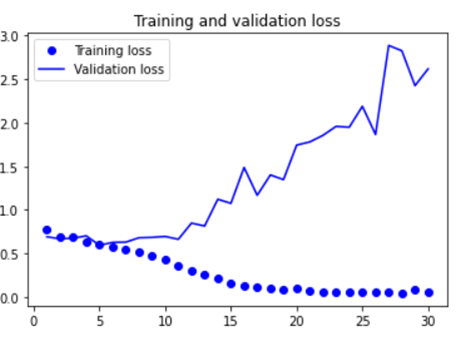


**Observations:**

•	The above plots are the representations of overfitting. Training accuracy increases linearly over time until it reaches nearly 100%, while validation accuracy reaches 70-72%.

•	With only a few training samples, overfitting will be our main concern. Overfitting can be reduced by a variety of techniques, such as dropout, regularization and data augmentation.

I have used three techniques to improve the performance of the model and evaluated all those three on test dataset on 100 epochs.

a) Drop out Method

b) Data Augmentation

c) Data Augmentation and drop out method.


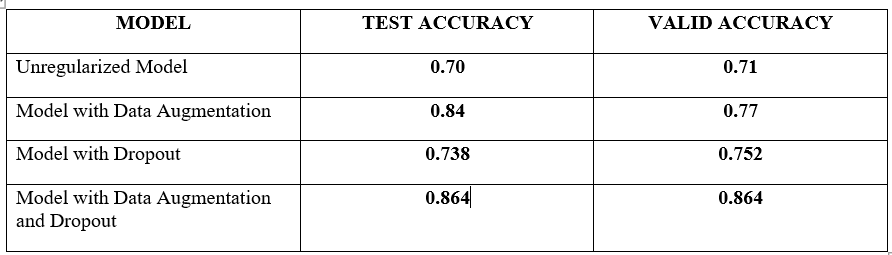


**Observations:**

•	According to the performance metrics of the models using three performance improvement techniques combined with the unregularised model, from the values of the above table we can say that the model with both data augmentation and drop out technique performs well. 

•	I have used this best performed technique i.e. data augmentation and drop out for the remaining training samples to regularize the model.


**2.Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?**

•	For this model I have increased the training sample size to 5000.


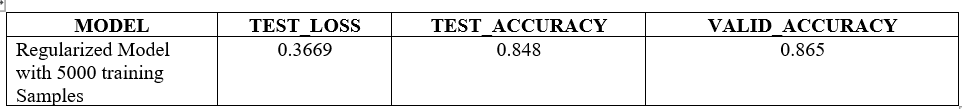


**Observations:**

•	For regularized model it is observed that the loss: 0.3669 - accuracy: 0.848.

•	In contrast to the unregularized model regularized model seems to have a bit higher accuracy.

•	In comparison to the previous model the accuracy seems to be improved while the loss is slightly reduced.


**3.Now change your training sample so that you achieve better performance than those from Steps1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results?**

•	For this model,I have increased sample size to 10000.

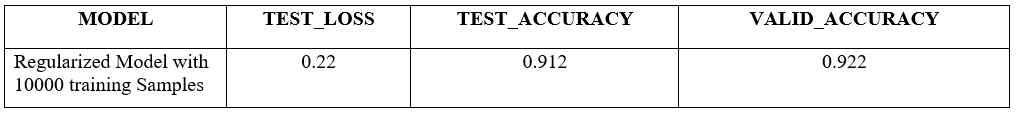


**Observations:**

From the above table, 

•	For regularized model it is observed that the loss: 0.22 - accuracy: 0.912

•	In comparison with the unregularized model, this model is better.

Below is the chart that describes the comparison of test and validation accuracies for the different training samples size.

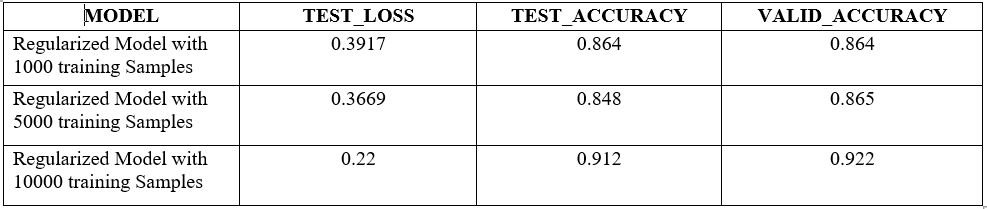


**Observations:**

•	There is a correlation between test loss and training sample size, which shows that test loss decreases over time and the test accuracy increases from 86% to 92.2%, which shows a better improvement over time.

•	Therefore, we can say that the performance of the model increases as the number of training samples increases.



**4.Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3,for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.**

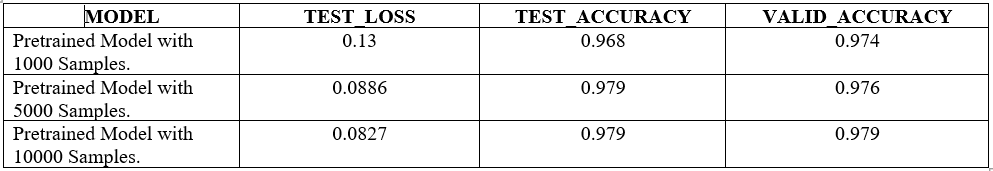

**Observations:**

From the values of the above table, we can see that the testing and validation accuracy both tend to improve as the training sample size increases. When we consider test loss, we see a better improvement as the sample size increases.


**Recommendations:**

Machine learning models that use convolutional networks are the most effective for computer vision. 

The results can be decent even with a very small dataset when training one from scratch.

The main problem with a small dataset is overfitting. When working with image data, data augmentation can be a powerful method of preventing overfitting.

With increasing training sample size, model performance also increases.

Even by fine-tuning the pre-trained model, we can enhance the performance of the model.

